In [144]:
import os
import sys
from typing import List, Dict

import lightgbm as lgb
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

# Code 경로 추가
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(""))))
print(sys.path[-1])

c:\Users\com\Desktop\AIT Project1\level1-classificationinmachinelearning-recsys-06


In [145]:
# 코드를 실행하기 위한 라이브러리 임포트
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

In [146]:
# 시드 값 설정 : 재현성을 위해 시드 값을 42로 설정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [147]:
# 파일 호출
data_path: str = "..\..\data"
## raw.csv가 없는 경우 실행
# from Code.dataset.merge_all import merge_all
# df = merge_all(data_path)
df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "raw.csv"))
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv"))  # ID, target 열만 가진 데이터 미리 호출

<>:2: SyntaxWarning:

invalid escape sequence '\.'

<>:2: SyntaxWarning:

invalid escape sequence '\.'

C:\Users\com\AppData\Local\Temp\ipykernel_5168\1108610658.py:2: SyntaxWarning:

invalid escape sequence '\.'



In [148]:
test_df = df.loc[df["_type"] == "test"]
test_df.isnull().sum()

ID                                                                     0
target                                                              2792
_type                                                                  0
hourly_market-data_coinbase-premium-index_coinbase_premium_gap         1
hourly_market-data_coinbase-premium-index_coinbase_premium_index       1
                                                                    ... 
hourly_network-data_tokens-transferred_tokens_transferred_median       0
hourly_network-data_transactions-count_transactions_count_total        4
hourly_network-data_transactions-count_transactions_count_mean         9
hourly_network-data_utxo-count_utxo_count                              1
hourly_network-data_velocity_velocity_supply_total                     0
Length: 255, dtype: int64

In [149]:
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close": "close",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume": "volume",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    'hourly_network-data_hashrate_hashrate': 'hashrate',
    'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio' : 'taker_buy_sell_ratio',
    'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume' : 'taker_sell_volume',
    'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume' : 'taker_buy_volume',
    'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest' : 'open_interest',
    'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations' : 'long_liquidations',
    'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations' : 'short_liquidations',
    'hourly_market-data_coinbase-premium-index_coinbase_premium_index' : 'coinbase_premium_index',
    'hourly_market-data_funding-rates_all_exchange_funding_rates' : 'funding_rates'
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)

In [150]:
lstm_df = df.loc[df["_type"] == "train"]

ema_period1 = 12
ema_period2 = 26

lstm_df['EMA_12'] = lstm_df['close'].ewm(span=ema_period1, adjust=False).mean()
lstm_df['EMA_26'] = lstm_df['close'].ewm(span=ema_period2, adjust=False).mean()

C:\Users\com\AppData\Local\Temp\ipykernel_5168\1239323175.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\com\AppData\Local\Temp\ipykernel_5168\1239323175.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [151]:
# RSI 계산 함수 정의
def calculate_rsi(data, period=14):
    delta = data.diff() # 일일 변화량 계산
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean() # 평균 상승
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean() # 평균 하락

    rs = gain / loss # 상대 강도(RS) 계산
    rsi = 100 - (100 / (1 + rs)) # RSI 계산
    return rsi

In [152]:
lstm_df['RSI'] = calculate_rsi(lstm_df['close'])

C:\Users\com\AppData\Local\Temp\ipykernel_5168\1896858981.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [153]:
lstm_df['MACD'] = lstm_df['EMA_12'] - lstm_df['EMA_26']
lstm_df['signal_line'] = lstm_df['MACD'].ewm(span=9, adjust=False).mean()
lstm_df['histogram'] = lstm_df['MACD'] - lstm_df['signal_line']

C:\Users\com\AppData\Local\Temp\ipykernel_5168\2623892819.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\com\AppData\Local\Temp\ipykernel_5168\2623892819.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\com\AppData\Local\Temp\ipykernel_5168\2623892819.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [154]:
lstm_df.head()

,ID,target,_type,close,volume,coinbase_premium_gap,hashrate,taker_buy_sell_ratio,taker_sell_volume,taker_buy_volume,...,long_liquidations,short_liquidations,coinbase_premium_index,funding_rates,EMA_12,EMA_26,RSI,MACD,signal_line,histogram
0,2023-01-01 00:00:00,2.0,train,16536.747967,5516.420322,-9.86,5.062917e+11,0.904774,5.137537e+07,4.648309e+07,...,0.012,0.000,-0.059650,0.005049,16536.747967,16536.747967,NaN,0.000000,0.000000,0.000000
1,2023-01-01 01:00:00,1.0,train,16557.136536,4513.341881,-8.78,1.687639e+11,1.655721,2.401129e+07,3.975599e+07,...,0.000,0.712,-0.053047,0.005049,16539.884670,16538.258232,NaN,1.626439,0.325288,1.301151
2,2023-01-01 02:00:00,1.0,train,16548.149805,4310.904314,-9.59,3.375278e+11,1.027512,2.340995e+07,2.405402e+07,...,0.000,0.000,-0.057952,0.005049,16541.156229,16538.990941,NaN,2.165289,0.693288,1.472001
3,2023-01-01 03:00:00,1.0,train,16533.632875,4893.417864,-9.74,2.109549e+11,0.874477,3.270773e+07,2.860215e+07,...,0.593,0.000,-0.058912,0.005067,16539.998790,16538.594047,NaN,1.404743,0.835579,0.569164
4,2023-01-01 04:00:00,2.0,train,16524.712159,5209.002297,-10.14,2.953368e+11,0.966796,3.193766e+07,3.087720e+07,...,0.361,0.000,-0.061373,0.006210,16537.647001,16537.565759,NaN,0.081242,0.684712,-0.603470


In [155]:
lstm_df.isnull().sum()

ID                         0
target                     0
_type                      0
close                      0
volume                     0
coinbase_premium_gap       5
hashrate                   0
taker_buy_sell_ratio       0
taker_sell_volume          0
taker_buy_volume           0
open_interest              0
long_liquidations          0
short_liquidations         0
coinbase_premium_index     5
funding_rates              0
EMA_12                     0
EMA_26                     0
RSI                       13
MACD                       0
signal_line                0
histogram                  0
dtype: int64

In [176]:
# Min-Max 정규화
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(lstm_df['close'].values.reshape(-1,1))

# 데이터셋 생성
def create_dataset(dataset, time_step=1):
    dataX, dataY = [],[]
    for i in range(len(dataset) - time_step -1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# 파라미터 설정
time_step = 720 # 기존 1에서 30으로 변경
X, y = create_dataset(scaled_data, time_step)

# 데이터셋 분할 (Train 80%, Test 20%)
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

# 날짜 인덱스 생성 : 시각화를 위해 인덱스 생성
train_dates = lstm_df.index[:train_size]
test_dates = lstm_df.index[train_size:len(X)]

# LSTM 모델 입력 형식에 맞게 데이터를 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2)) # 드랍아웃 추가
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2)) # 드랍아웃 추가
model.add(Dense(25))
model.add(Dense(1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 모델 훈련
model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20


c:\Users\com\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



201/201 ━━━━━━━━━━━━━━━━━━━━ 59s 276ms/step - loss: 0.0209 - val_loss: 3.1084e-04
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 273ms/step - loss: 9.2033e-04 - val_loss: 2.2124e-04
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 276ms/step - loss: 6.2109e-04 - val_loss: 1.8689e-04
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 278ms/step - loss: 4.2427e-04 - val_loss: 1.8065e-04
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s 277ms/step - loss: 3.2300e-04 - val_loss: 1.5416e-04
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 55s 275ms/step - loss: 2.3558e-04 - val_loss: 3.3145e-04
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 57s 283ms/step - loss: 2.0812e-04 - val_loss: 1.4684e-04
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 2.0455e-04 - val_loss: 2.3431e-04
Epoch 9/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 54s 268ms/step - loss: 1.8257e-04 - val_loss: 3.5973e-04
Epoch 10/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 59s 294ms/step - loss: 1.7968e-04 - val_loss: 3.4733e-04
Epoch 11/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 56s

In [177]:
# 예측 : 훈련 데이터와 테스트 데이터에 대해 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step


In [178]:
# 데이터 역변환 : 예측값과 실제값을 원래 스케일로 복원
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [179]:
# RMSE 계산
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 334.50
Test RMSE: 501.87


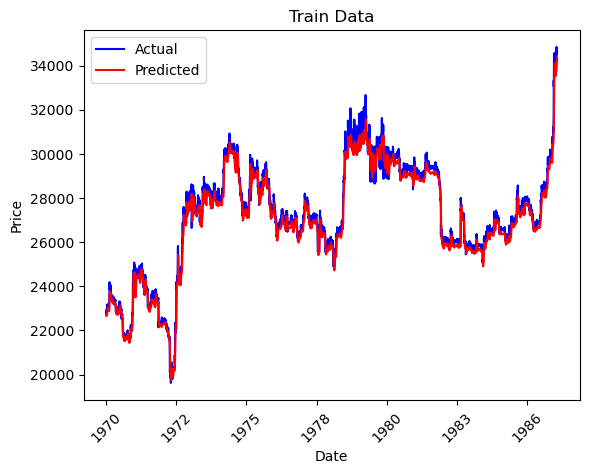

In [182]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 훈련 데이터 시각화
from matplotlib.dates import DateFormatter
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

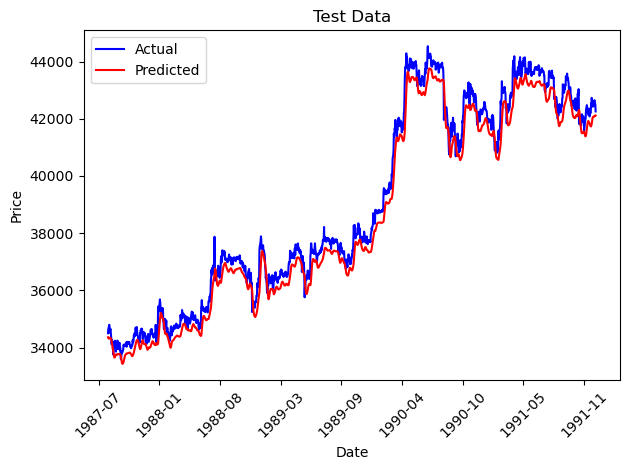

In [183]:
# 테스트 데이터 시각화
plt.subplot(1, 1, 1)
plt.plot(test_dates, y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates, test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [184]:
submission = pd.read_csv('../../data/sample_submission.csv')

In [185]:
# 예측할 미래 데이터 준비
last_1_days = scaled_data[-time_step:]
X_predict = last_1_days.reshape(1, time_step, 1)

# 예측 수행
future_predictions = []
for _ in range(len(submission)):
    pred = model.predict(X_predict)
    future_predictions.append(pred[0, 0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, time_step, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

In [186]:
# 스케일링 복원
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [187]:
# 결과 저장
submission['Close'] = future_predictions

submission['Price Change'] = submission['Close'].diff().shift(-1)
submission

,ID,target,Close,Price Change
0,2024-01-01 00:00:00,-1,42029.750000,-77.660156
1,2024-01-01 01:00:00,-1,41952.089844,-95.316406
2,2024-01-01 02:00:00,-1,41856.773438,-106.000000
3,2024-01-01 03:00:00,-1,41750.773438,-112.476562
4,2024-01-01 04:00:00,-1,41638.296875,-116.363281
...,...,...,...,...
2787,2024-04-26 03:00:00,-1,18255.083984,0.000000
2788,2024-04-26 04:00:00,-1,18255.083984,0.000000
2789,2024-04-26 05:00:00,-1,18255.083984,0.000000
2790,2024-04-26 06:00:00,-1,18255.083984,0.000000


In [188]:
submission['diff_percent'] = submission['Price Change'] / submission['Close']
submission

,ID,target,Close,Price Change,diff_percent
0,2024-01-01 00:00:00,-1,42029.750000,-77.660156,-0.001848
1,2024-01-01 01:00:00,-1,41952.089844,-95.316406,-0.002272
2,2024-01-01 02:00:00,-1,41856.773438,-106.000000,-0.002532
3,2024-01-01 03:00:00,-1,41750.773438,-112.476562,-0.002694
4,2024-01-01 04:00:00,-1,41638.296875,-116.363281,-0.002795
...,...,...,...,...,...
2787,2024-04-26 03:00:00,-1,18255.083984,0.000000,0.000000
2788,2024-04-26 04:00:00,-1,18255.083984,0.000000,0.000000
2789,2024-04-26 05:00:00,-1,18255.083984,0.000000,0.000000
2790,2024-04-26 06:00:00,-1,18255.083984,0.000000,0.000000


In [199]:
fig: go.Figure = make_subplots(
    
)

fig.add_trace(go.Line(x=submission['ID'], y=submission['Close']))
fig.update_layout(
    width =700,
    height = 500
)
fig.show()

In [190]:
def categorize_change(change):
    if change < -0.005:
        return 0
    elif -0.005 <= change < 0:
        return 1
    elif 0 <= change < 0.005:
        return 2
    else:
        return 3

In [191]:
submission['target'] = [categorize_change(x) for x in submission['diff_percent']]
submission

,ID,target,Close,Price Change,diff_percent
0,2024-01-01 00:00:00,1,42029.750000,-77.660156,-0.001848
1,2024-01-01 01:00:00,1,41952.089844,-95.316406,-0.002272
2,2024-01-01 02:00:00,1,41856.773438,-106.000000,-0.002532
3,2024-01-01 03:00:00,1,41750.773438,-112.476562,-0.002694
4,2024-01-01 04:00:00,1,41638.296875,-116.363281,-0.002795
...,...,...,...,...,...
2787,2024-04-26 03:00:00,2,18255.083984,0.000000,0.000000
2788,2024-04-26 04:00:00,2,18255.083984,0.000000,0.000000
2789,2024-04-26 05:00:00,2,18255.083984,0.000000,0.000000
2790,2024-04-26 06:00:00,2,18255.083984,0.000000,0.000000


In [192]:
submission['target'].value_counts()

target
1    1438
2    1353
3       1
Name: count, dtype: int64